## Context

ABC Supermarket is planning for the year-end sale - they want to launch a new offer i.e. gold membership for only \\$499 that is of \\$999 on normal days (that gives 20% discount on all purchases) only for existing customers, for that they need to do a campaign through phone calls - the best way to reduce the cost of the campaign is to make a predictive model to classify customers who might purchase the offer, using the data they gathered during last year's campaign.

We will build a model for classifying whether customers will reply with a positive
response or not.

## Import Statements

In [174]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [175]:
df = pd.read_excel("marketing_data.xlsx")

## Column Definitions

- Response (target) - 1 if customer accepted the offer in the last campaign, 0
otherwise
- Complain - 1 if a customer complained in the last 2 years
- DtCustomer - date of customer’s enrolment with the company
- Education - customer’s level of education
- Marital - customer’s marital status
- Kidhome - number of small children in customer’s household
- Teenhome - number of teenagers in customer’s household
- Income - customer’s yearly household income
- MntFishProducts - the amount spent on fish products in the last 2 years
- MntMeatProducts - the amount spent on meat products in the last 2 years
- MntFruits - the amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntWines - the amount spent on wine products in the last 2 years
- MntGoldProds - the amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalog
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through the company’s web site
- NumWebVisitsMonth - number of visits to company’s web site in the last month
- Recency - number of days since the last purchase
- ID - unique customer-id
- Year_Birth - customer's year of birth

## Data Profiling

In [176]:
# df.dtypes
# df.isnull().sum()
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/14,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/14,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/14,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05 00:00:00,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04 00:00:00,0,6,...,11,0,34,2,3,1,2,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,2013-07-03 00:00:00,99,372,...,47,48,78,2,5,2,11,4,0,0
2236,5263,1977,2n Cycle,Married,31056.0,1,0,1/22/13,99,5,...,3,8,16,1,1,0,3,8,0,0
2237,22,1976,Graduation,Divorced,46310.0,1,0,2012-03-12 00:00:00,99,185,...,15,5,14,2,6,1,5,8,0,0
2238,528,1978,Graduation,Married,65819.0,0,0,11/29/12,99,267,...,149,165,63,1,5,4,10,3,0,0


In [177]:
# # Dropping dupes and retaining only 1 entry
df = df.drop(columns=['ID'])
df = df.drop_duplicates(keep='last')
df

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1970,Graduation,Divorced,84835.0,0,0,6/16/14,0,189,104,...,111,189,218,1,4,4,6,1,1,0
1,1961,Graduation,Single,57091.0,0,0,6/15/14,0,464,5,...,7,0,37,1,7,3,7,5,1,0
2,1958,Graduation,Married,67267.0,0,1,5/13/14,0,134,11,...,15,2,30,1,3,2,5,2,0,0
3,1967,Graduation,Together,32474.0,1,1,2014-11-05 00:00:00,0,10,0,...,0,0,0,1,1,0,2,7,0,0
4,1989,Graduation,Single,21474.0,1,0,2014-08-04 00:00:00,0,6,16,...,11,0,34,2,3,1,2,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1976,PhD,Divorced,66476.0,0,1,2013-07-03 00:00:00,99,372,18,...,47,48,78,2,5,2,11,4,0,0
2236,1977,2n Cycle,Married,31056.0,1,0,1/22/13,99,5,10,...,3,8,16,1,1,0,3,8,0,0
2237,1976,Graduation,Divorced,46310.0,1,0,2012-03-12 00:00:00,99,185,2,...,15,5,14,2,6,1,5,8,0,0
2238,1978,Graduation,Married,65819.0,0,0,11/29/12,99,267,38,...,149,165,63,1,5,4,10,3,0,0


In [178]:
# Extracting Year from customer's date of enrolment and only retaining the Year
from datetime import datetime

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%y')
# df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer'] = df['Dt_Customer'].dt.year

In [179]:
# Removing Customer Records with Year_Birth earlier than 1940; replaced by STD Method
# def remove_centennial_cust(df):
#     return df[df['Year_Birth']>=1940]

# df = remove_centennial_cust(df)

In [180]:
# Change Alone, Absurd, YOLO to Single
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
df['Marital_Status'] = df['Marital_Status'].replace('Absurd', 'Single')
df['Marital_Status'] = df['Marital_Status'].replace('YOLO', 'Single')

In [181]:
# Populating Missing Income with Median with Similar Education and MaritalStatus; Changed to fill 0; May be modified to use median of all entries
# median = df.groupby(['Education', 'Marital_Status'])['Income'].transform('median')
# df['Income'] = df['Income'].fillna(median)
# df['Income'] = df['Income'].fillna(df['Income'].median())
df['Income'] = df['Income'].fillna(0)

In [182]:
# Convert Year_Birth to Age
df['Age'] = 2015 - df['Year_Birth']
df.drop(columns=['Year_Birth'],inplace=True)

### Removing Outliers

In [183]:
# Dropping Outliers in Income using STD method; Used
income = df['Income'].values
mean = np.mean(income)
std = np.std(income)

threshold_lower = mean - 2 * std
threshold_upper = mean + 2 * std

df = df[(df['Income'] >= threshold_lower) & (df['Income'] <= threshold_upper)]

In [184]:
df['Education'].value_counts()

Education
Graduation    1026
PhD            445
Master         340
2n Cycle       188
Basic           49
Name: count, dtype: int64

In [185]:
# Dropping Outliers in Income using IQR Method
# def remove_outliers(df, threshold=2):
#     Q1 = df['Income'].quantile(0.25)
#     Q3 = df['Income'].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - threshold * IQR
#     upper_bound = Q3 + threshold * IQR
#     return df[(df['Income'] > lower_bound) & (df['Income'] < upper_bound)]


# df = remove_outliers(df)

count      2048.000000
mean      51027.200684
std       21254.662270
min           0.000000
25%       34722.000000
50%       51075.000000
75%       67897.500000
max      102692.000000
Name: Income, dtype: float64

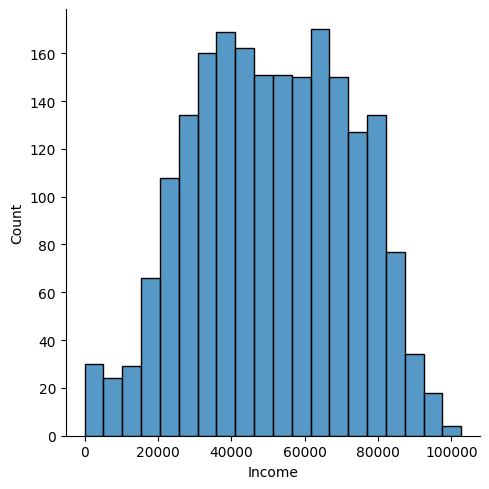

In [186]:
sns.displot(df['Income'])
df['Income'].describe()

In [187]:
# Dropping Outliers in Age using STD method
income = df['Age'].values
mean = np.mean(income)
std = np.std(income)

threshold_lower = mean - 2 * std
threshold_upper = mean + 2 * std

df = df[(df['Age'] >= threshold_lower) & (df['Age'] <= threshold_upper)]

count    2017.000000
mean       46.083788
std        11.351763
min        23.000000
25%        38.000000
50%        45.000000
75%        56.000000
max        70.000000
Name: Age, dtype: float64

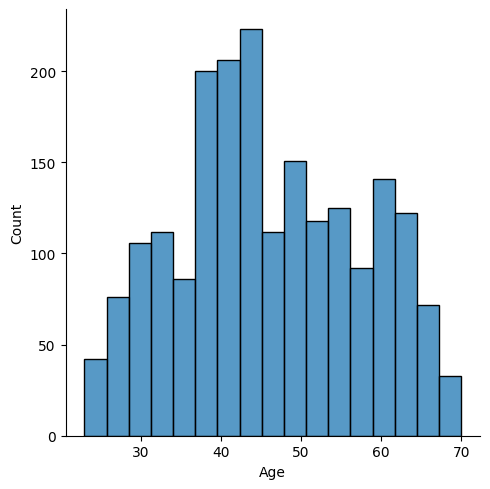

In [188]:
sns.displot(df['Age'])
df['Age'].describe()

In [189]:
df

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age
0,Graduation,Divorced,84835.0,0,0,2014,0,189,104,379,...,189,218,1,4,4,6,1,1,0,45
1,Graduation,Single,57091.0,0,0,2014,0,464,5,64,...,0,37,1,7,3,7,5,1,0,54
2,Graduation,Married,67267.0,0,1,2014,0,134,11,59,...,2,30,1,3,2,5,2,0,0,57
3,Graduation,Together,32474.0,1,1,2014,0,10,0,1,...,0,0,1,1,0,2,7,0,0,48
4,Graduation,Single,21474.0,1,0,2014,0,6,16,24,...,0,34,2,3,1,2,7,1,0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,PhD,Divorced,66476.0,0,1,2013,99,372,18,126,...,48,78,2,5,2,11,4,0,0,39
2236,2n Cycle,Married,31056.0,1,0,2013,99,5,10,13,...,8,16,1,1,0,3,8,0,0,38
2237,Graduation,Divorced,46310.0,1,0,2012,99,185,2,88,...,5,14,2,6,1,5,8,0,0,39
2238,Graduation,Married,65819.0,0,0,2012,99,267,38,701,...,165,63,1,5,4,10,3,0,0,37


### Feature Engineering

In [190]:
# Ratio of Mnt column to the total of Mnt Column; Assuming that the formulas are correct, no effect

df['MntTotal'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
sum = df['MntTotal'].sum()
aveSum = sum/ len(df)
df['Ratio'] = df['MntTotal']/aveSum
# df.drop(columns=['MntTotal'],inplace=True)

In [191]:
df['TotalPurchases'] = df[['NumDealsPurchases','NumCatalogPurchases','NumWebPurchases','NumStorePurchases']].sum(axis=1)

In [192]:
# WebTransactions Not helpful
# df['WebTransactions'] = df['NumWebPurchases']**2/df['NumWebVisitsMonth']
# df.replace([np.inf,-np.inf, np.nan],0, inplace=True)

In [193]:
# Total # of Children and Identify if Single Parent
# No effect if no other column is removed
df['TotalChildren'] = df['Kidhome']+df['Teenhome']
df['SingleParent'] = False

# Single
SingleParentMask = (df['Marital_Status'] == 'Single') & (df['TotalChildren']>0)
df.loc[SingleParentMask, 'SingleParent'] = True

# Widow
SingleParentMask = (df['Marital_Status'] == 'Widow') & (df['TotalChildren']>0)
df.loc[SingleParentMask, 'SingleParent'] = True

# Divorced
SingleParentMask = (df['Marital_Status'] == 'Divorced') & (df['TotalChildren']>0)
df.loc[SingleParentMask, 'SingleParent'] = True

# Incentivize DealsPurchases if SingleParent, No Effect
df.loc[df['SingleParent'], 'NumDealsPurchases'] **=2

In [194]:
## If Married and Together with kids No effect; Redundant
# df['NotSingleParent']=False
# df.loc[((df['Marital_Status'].isin(['Married', 'Together'])) & df['TotalChildren']>0),'NotSingleParent']=True

In [195]:
# If with kids Not helpful; Redundant
# df['Parent']=False
# df.loc[((df['Marital_Status'].isin(['Married', 'Together', 'Widow', 'Single', 'Divorced'])) & df['TotalChildren']>0),'Parent']=True

In [196]:
# Total # of people in the household
df['HouseholdCount'] = 1
df['HouseholdCount'] += df['TotalChildren']
df.loc[df['Marital_Status'].isin(['Married','Together']),'HouseholdCount'] += 1

In [197]:
# Income to MNT total No Effect
# df['BoughtItems'] = df['Income']/(df['MntProducts']+df['MntSweetProducts']+df['MntWines']+df['MntFruits']+df['MntGoldProds']
#                                            +df['MntMeatFishProducts'])

In [198]:
# No Effect
# bins = [0, 24, 177, 505, 1500]
# labels = [1,2,3,4]

# df['MntWinesNum'] = pd.cut(df['MntWines'],bins=bins, labels=labels, right=False)
# df['MntWinesNum'] = df['MntWinesNum'].astype(int)

In [199]:
## RecencyRelevance
# df['RecencyRelevance'] = df['Recency']**2/(df['MntFishProducts']+df['MntFruits']+df['MntGoldProds']
#                                            +df['MntMeatProducts']+df['MntSweetProducts']+df['MntWines'])

## Initial Exploratory Data Analysis

In [200]:
# colors = sns.color_palette('pastel')[0:len(df['Response'].value_counts())]

# #create pie chart
# plt.pie(df['Response'].value_counts(), labels=['Didnt Accept', 'Accepted'], colors = colors, autopct='%.0f%%')
# plt.legend()
# plt.show()

In [201]:
# colors = sns.color_palette('pastel')[0:len(df['Complain'].value_counts())]

# #create pie chart
# plt.pie(df['Complain'].value_counts(), labels=['Didnt Complain', 'Complained'], colors = colors, autopct='%.0f%%')
# plt.legend()
# plt.show()

In [202]:
# sns.barplot(x = 'Income', y = 'count', data=df[['Income']].value_counts().reset_index(name='count'))
# sns.countplot(x='Income',data=df_complaints)
# plt.xticks(rotation=45)
# plt.show()
# df

In [203]:
# sns.barplot(x = 'Complain', y='count', hue = 'Response',data=df[['Complain', 'Response']].value_counts().reset_index())
    
# plt.show()

In [204]:
# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# for i, ax, col in zip(range(2), axes.flat, ['Kidhome', 'Teenhome']):
#     tmp = df[[col, 'Response']].value_counts().to_frame().reset_index()
#     tmp['Response'] = tmp['Response'].replace({0: 'Didnt Accept', 1: 'Accepted'})

#     sns.barplot(x = col, y='count', 
#                    hue = 'Response',data=tmp, ax=ax)
    
# plt.show()

In [205]:
# fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))

# for i, ax, col in zip(range(6), axes.flat, ['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntWines', 'MntGoldProds']):
#     sns.kdeplot(df, x=col, hue='Response', fill=True, ax=ax)
    
# plt.show()

## Baseline Modelling

In [206]:
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first=True, prefix=column+suffix)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

In [207]:
df = one_hot_encode(df, 'Education')
df = one_hot_encode(df, 'Marital_Status')

In [208]:
# df.columns

In [209]:
# df = df[['Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
#        'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
#        'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
#        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
#        'Response', 'Complain', 'Age', 'MntTotal', 'Ratio', 'TotalPurchases',
#        'TotalChildren', 'SingleParent', 'NotSingleParent', 'HouseholdCount',
#        'Education_Basic', 'Education_Graduation', 'Education_Master',
#        'Education_PhD', 'Marital_Status_Married', 'Marital_Status_Single',
#        'Marital_Status_Together', 'Marital_Status_Widow']]

In [210]:
# X = df.drop('Response', axis=1).iloc[:,1:][['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntWines', 'MntGoldProds']]
X = df.drop(['Response', 'Complain'], axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [211]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# from sklearn.

In [212]:
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)


In [213]:
# Table for Model Comparison
# classifiers = {
#     'Logistic Regression': LogisticRegression(),
#     'Gaussian Naive Bayes': GaussianNB(),
#     'Decision Tree': DecisionTreeClassifier(),
#     'SVC': SVC(),
#     'K Nearest Neighbors': KNeighborsClassifier()
# }

# metricsList = []

# for name, clf in classifiers.items():
#     clf.fit(X_train,y_train)

#     preds = clf.predict(scaler.transform(X_test))

#     # Scores
#     acc = accuracy_score(y_test, preds)
#     prec = precision_score(y_test, preds)
#     rec = recall_score(y_test, preds)
#     f1 = f1_score(y_test, preds)
#     auc = roc_auc_score(y_test, preds)
#     trainScore = clf.score(X_train, y_train)
#     testScore = clf.score(X_test, y_test)

#     metrics = {
#         'Classifier': name,
#         'Accuracy': format(acc,'.4f'),
#         'Precision': format(prec,'.4f'),
#         'Recall': format(rec,'.4f'),
#         'F1 Score': format(f1,'.4f'),
#         'AUC': format(auc,'.4f'),
#         'Training': format(trainScore, '.4f'),
#         'Test': format(testScore, '.4f'),
#     }

#     metricsList.append(metrics)

# metrics_df = pd.DataFrame(metricsList)

# metrics_df

In [214]:
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import GridSearchCV

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm=SVC() 
svm.fit(X_train,y_train)

scorer = make_scorer(precision_score, average='binary', zero_division=0)
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']}

grid_search = GridSearchCV(estimator=svm, scoring=scorer, param_grid=param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test_scaled, y_test)))

GridSearch CV best score : 0.9179


Parameters that give the best results : 

 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=1, gamma=0.1)
GridSearch CV score on test set: 0.6190


In [215]:
svm = grid_search.best_estimator_
svm.fit(X_train_scaled,y_train)
svm_pred_train = svm.predict(X_train_scaled)
svm_pred_test = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred_test)
svm_prec = precision_score(y_test, svm_pred_test)
svm_rec = recall_score(y_test, svm_pred_test)
svm_f1 = f1_score(y_test, svm_pred_test)
svm_auc = roc_auc_score(y_test, svm_pred_test)
print("Support Vector Machines Accuracy: %.4f" % svm_acc)
print("Support Vector Machines Precision: %.4f" % svm_prec)
print("Support Vector Machines Recall: %.4f" % svm_rec)
print("Support Vector Machines F1: %.4f" % svm_f1)
print("Support Vector Machines AUC: %.4f" % svm_auc)

svm_prec_train = precision_score(y_train, svm_pred_train)
svm_prec_test = precision_score(y_test, svm_pred_test)
# Check for overfitting
print('Training set score: {:.4f}'.format(svm_prec_train))
print('Test set score: {:.4f}'.format(svm_prec_test))

Support Vector Machines Accuracy: 0.8738
Support Vector Machines Precision: 0.6190
Support Vector Machines Recall: 0.4262
Support Vector Machines F1: 0.5049
Support Vector Machines AUC: 0.6898
Training set score: 0.9622
Test set score: 0.6190


In [131]:
clf = LogisticRegression().fit(X_train, y_train)
preds = clf.predict(scaler.transform(X_test))

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, preds)

print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

# Check for overfitting
print('\nTraining set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Accuracy: 0.6807
Precision: 0.2424
Recall: 0.5246
F1: 0.3316
AUC: 0.6165

Training set score: 0.7055
Test set score: 0.7277


C:\Users\Predator\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Predator\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Result Matrix and Graphs

In [44]:
# conf_mat = confusion_matrix(y_test, preds)
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()

In [45]:
## Feature Importance
# feature_names = X.columns
# plt.figure(figsize=(10, 6))
# plt.barh(np.arange(len(feature_names)), clf.coef_[0], color='skyblue')
# plt.yticks(np.arange(len(feature_names)), feature_names)
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Logistic Regression Coefficients')
# plt.grid(True)
# plt.show()